# Modeling

In [2]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn import preprocessing

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

set_config(display="diagram")

df = pd.read_csv('data/vehicles_prepared.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264083 entries, 0 to 264082
Data columns (total 42 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   price                     264083 non-null  int64  
 1   year                      264083 non-null  float64
 2   manufacturer              264083 non-null  object 
 3   cylinders                 264083 non-null  int64  
 4   odometer                  264083 non-null  float64
 5   condition__excellent      264083 non-null  int64  
 6   condition__fair           264083 non-null  int64  
 7   condition__good           264083 non-null  int64  
 8   condition__like new       264083 non-null  int64  
 9   condition__new            264083 non-null  int64  
 10  condition__other          264083 non-null  int64  
 11  condition__salvage        264083 non-null  int64  
 12  fuel__diesel              264083 non-null  int64  
 13  fuel__electric            264083 non-null  i

### Labels and categoricals

In [3]:
# use LabelEncoder to encode categorical features
label_encoder = preprocessing.LabelEncoder()

df['manufacturer'] = label_encoder.fit_transform(df['manufacturer'])

### Train / Test split

In [4]:
X = df.drop('price', axis = 1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.3)

### Scaling

In [5]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train= sc.fit_transform(X_train)
X_test= sc.transform(X_test)

### Simple Linear regression

In [6]:
model = LinearRegression()
model.fit(X_train,y_train)

print(model.intercept_)

coeff_parameter = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coeff_parameter.sort_values(by='Coefficient', ascending=False)

19800.64234340064


,Coefficient
drive__4wd,1.004693e+15
drive__fwd,9.855504e+14
drive__rwd,7.790640e+14
fuel__gas,4.974402e+14
fuel__other,3.948897e+14
fuel__diesel,2.869858e+14
fuel__hybrid,1.623277e+14
fuel__electric,9.445616e+13
year,5.536984e+03
cylinders,2.204360e+03


Text(0.5, 0, 'Price')

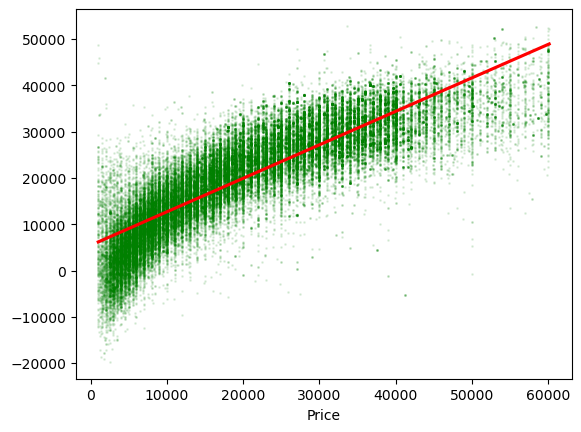

In [7]:
predictions = model.predict(X_test)
sns.regplot(x=y_test, y=predictions, scatter_kws={"color": "green", "alpha": 0.1, "s":1 }, line_kws={"color": "red"})
plt.xlabel('Price')

In [8]:
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_mse = mean_squared_error(y_train, train_preds)
test_mse = mean_squared_error(y_test, test_preds)

print(f'Train MSE: {train_mse: .2f}')
print(f'Test MSE: {test_mse: .2f}')

Train MSE:  44037614.18
Test MSE:  44769913.16


The line fits pretty good, but we can see that a linear approximation is not enough, we need polynomial features

### Polynomial Features

In [9]:
poly_features = PolynomialFeatures(degree = 2, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.fit_transform(X_test)

columns = poly_features.get_feature_names_out()

train_df = pd.DataFrame(X_train_poly, columns=columns)
test_df = pd.DataFrame(X_test_poly, columns=columns)

### Sequential Feature selection

In [10]:
selector = SequentialFeatureSelector(LinearRegression(), n_features_to_select=3, scoring='neg_mean_squared_error')
best_features = selector.fit_transform(train_df, y_train)
best_features_df = pd.DataFrame(best_features, columns = selector.get_feature_names_out())

best_features_df.head()

,x0,x2,x11
0,-0.193673,0.054758,-0.220674
1,0.772723,-1.522798,4.531576
2,0.386164,1.632313,-0.220674
3,-0.386953,1.632313,4.531576
4,-1.933187,0.054758,-0.220674


In [11]:
pipe = Pipeline([('column_selector', selector),
                ('linreg', LinearRegression())])

pipe.fit(train_df, y_train)

train_preds = pipe.predict(train_df)
test_preds = pipe.predict(test_df)

train_mse = mean_squared_error(y_train, train_preds)
test_mse = mean_squared_error(y_test, test_preds)

print(f'Train MSE: {train_mse: .2f}')
print(f'Test MSE: {test_mse: .2f}')

# 3 features, degree 3
# Train MSE:  65431691.40
# Test MSE:  65910715.47

# 4 features, degree 3
# Train MSE:  57473115.73
# Test MSE:  57921345.80

# 3 features, degree 4



Train MSE:  65431691.40
Test MSE:  65910715.47


<Axes: xlabel='price'>

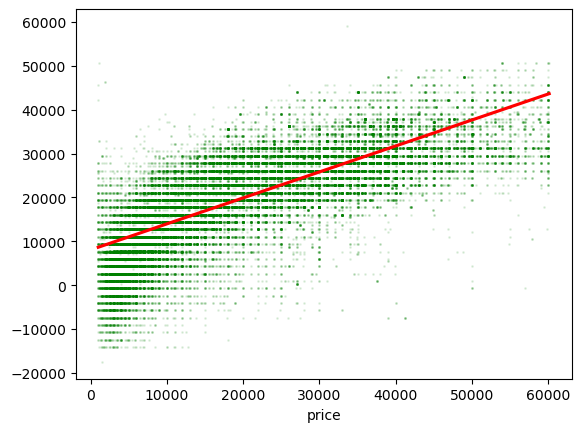

In [12]:
sns.regplot(x=y_test, y=test_preds, scatter_kws={"color": "green", "alpha": 0.1, "s":1 }, line_kws={"color": "red"})